In [51]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing the Libraries

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load Data, Data Cleaning & Preprocessing

In [53]:
# Load data
df = pd.read_csv('/content/drive/MyDrive/Teknologi-Informasi/Praktikum-BigData/nvda.us.txt')

In [54]:
df.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,1999-01-22,1.6238,1.8092,1.4379,1.5215,18297633,0
1,1999-01-25,1.6423,1.6980,1.5215,1.6793,3445279,0
2,1999-01-26,1.6980,1.7350,1.5311,1.5494,2320993,0
3,1999-01-27,1.5586,1.5957,1.4660,1.5494,1662658,0
4,1999-01-28,1.5494,1.5586,1.5311,1.5401,1540110,0


In [55]:
# 1. DATA CLEANING
print("--- 1. Data Cleaning ---")

# Ubah kolom Date menjadi tipe datetime dan urutkan
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df = df.set_index('Date')
print(f"DataFrame awal: {df.shape[0]} baris.")

# Siapkan dataframe khusus untuk membuat feature
data = df[['Close']].copy()

--- 1. Data Cleaning ---
DataFrame awal: 4733 baris.


In [56]:
# --- 2. FEATURE ENGINEERING (DIPERBAIKI DENGAN IDE BARU) ---
print("\n--- 2. Data Preprocessing (Feature Engineering) ---")

# FITUR BARU
# Lagged Close Prices
df['Close_Lag_1'] = df['Close'].shift(1)
df['Close_Lag_2'] = df['Close'].shift(2) # <--- TAMBAHAN
df['Close_Lag_3'] = df['Close'].shift(3)
df['Close_Lag_7'] = df['Close'].shift(7) # <--- TAMBAHAN
# ...

# Moving Averages (MA)
df['MA_5_Lag1'] = df['Close'].rolling(window=5).mean().shift(1)
df['MA_10_Lag1'] = df['Close'].rolling(window=10).mean().shift(1)
df['MA_20_Lag1'] = df['Close'].rolling(window=20).mean().shift(1)
df['MA_50_Lag1'] = df['Close'].rolling(window=50).mean().shift(1) # <--- TAMBAHAN
df['MA_200_Lag1'] = df['Close'].rolling(window=200).mean().shift(1) # <--- TAMBAHAN

df['Open_Lag_1'] = df['Open'].shift(1)
df['High_Lag_1'] = df['High'].shift(1)
df['Low_Lag_1'] = df['Low'].shift(1)
df['Volume_Lag_1'] = df['Volume'].shift(1)

# Hapus baris NaN akibat shift/rolling
df_model = df.dropna()

# --- 3. SPLIT DATA ---
TEST_SIZE_RATIO = 0.3
split_point = int(len(df_model) * (1 - TEST_SIZE_RATIO))

# Definisikan Fitur: Gunakan SEMUA fitur Lagged yang baru dibuat
features_to_use = [
    'Close_Lag_1', 'Close_Lag_3',
    'MA_5_Lag1', 'MA_10_Lag1', 'MA_20_Lag1',
    'Open_Lag_1', 'High_Lag_1', 'Low_Lag_1', 'Volume_Lag_1',
    'Close_Lag_2', 'Close_Lag_7', 'MA_50_Lag1', 'MA_200_Lag1'
]

X = df_model[features_to_use]
Y = df_model['Close']

# Pembagian Sekuensial
X_train = X.iloc[:split_point]
X_test = X.iloc[split_point:]
Y_train = Y.iloc[:split_point]
Y_test = Y.iloc[split_point:]

print(f"\nDATA SPLITTING ({int((1 - TEST_SIZE_RATIO) * 100)}% Train, {int(TEST_SIZE_RATIO * 100)}% Test)")
print(f"Fitur: {features_to_use}\n")

df_model.head()


--- 2. Data Preprocessing (Feature Engineering) ---

DATA SPLITTING (70% Train, 30% Test)
Fitur: ['Close_Lag_1', 'Close_Lag_3', 'MA_5_Lag1', 'MA_10_Lag1', 'MA_20_Lag1', 'Open_Lag_1', 'High_Lag_1', 'Low_Lag_1', 'Volume_Lag_1', 'Close_Lag_2', 'Close_Lag_7', 'MA_50_Lag1', 'MA_200_Lag1']



,Open,High,Low,Close,Volume,OpenInt,Close_Lag_1,Close_Lag_2,Close_Lag_3,Close_Lag_7,MA_5_Lag1,MA_10_Lag1,MA_20_Lag1,MA_50_Lag1,MA_200_Lag1,Open_Lag_1,High_Lag_1,Low_Lag_1,Volume_Lag_1
Date,,,,,,,,,,,,,,,,,,,
1999-11-05,2.3196,2.3379,2.0784,2.1803,4159552,0,2.2544,2.1245,1.9300,1.6607,1.96688,1.80729,1.73356,1.782464,1.586631,2.1432,2.3196,2.1432,8500502.0
1999-11-08,2.1154,2.3101,2.0504,2.2450,3183041,0,2.1803,2.2544,2.1245,1.5864,2.06154,1.85832,1.75165,1.788030,1.589925,2.3196,2.3379,2.0784,4159552.0
1999-11-09,2.2450,2.2544,2.1245,2.2175,1848258,0,2.2450,2.1803,2.2544,1.7070,2.14684,1.92418,1.77529,1.792662,1.592754,2.1154,2.3101,2.0504,3183041.0
1999-11-10,2.2175,2.2266,2.1524,2.1896,970690,0,2.2175,2.2450,2.1803,1.8185,2.20434,1.97243,1.79895,1.796930,1.596094,2.2450,2.2544,2.1245,1848258.0
1999-11-11,2.1896,2.4678,2.1432,2.3476,3794815,0,2.1896,2.2175,2.2450,1.9300,2.21736,2.02532,1.82353,1.797302,1.599295,2.2175,2.2266,2.1524,970690.0


# Modeling

## Linear Regression

In [57]:
# 3. MODELING & EVALUATION
print("\n--- 3. Modeling & Evaluation ---")

# MODELING (DIPERBAIKI: Hapus parameter n_estimators)
lr_model = LinearRegression()
lr_model.fit(X_train, Y_train)

# Prediksi
lr_pred = lr_model.predict(X_test)


--- 3. Modeling & Evaluation ---


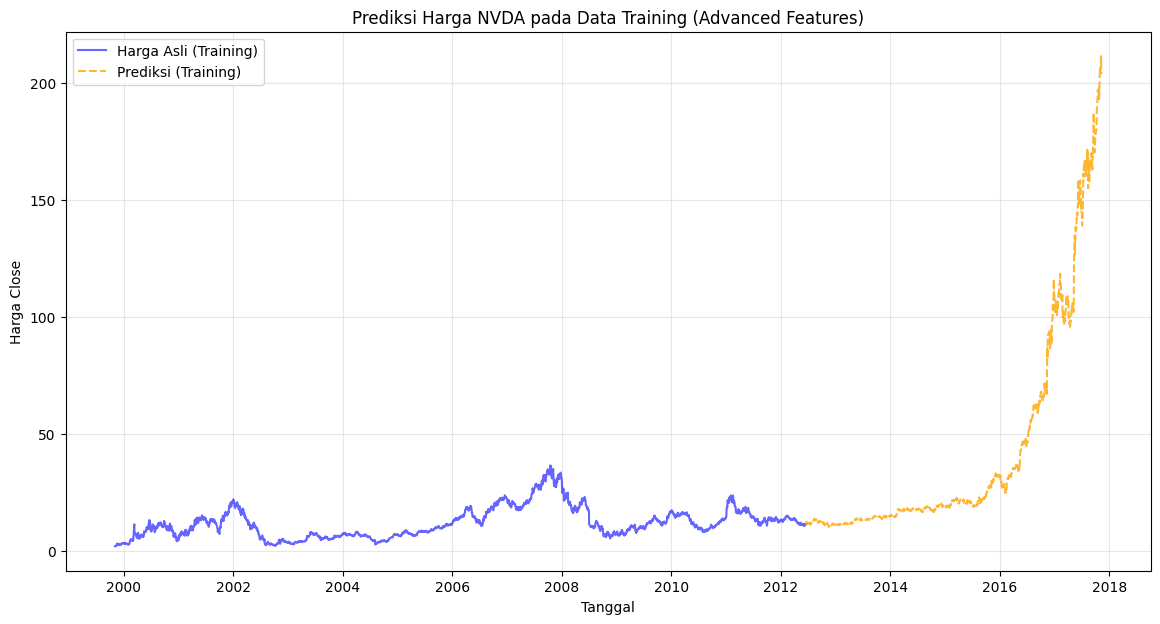

In [58]:
# --- VISUALISASI TRAINING DATA ---
plt.figure(figsize=(14, 7))

# Plot harga asli training
plt.plot(X_train.index, Y_train, label='Harga Asli (Training)', color='blue', alpha=0.6)

# Plot prediksi training
plt.plot(X_test.index, lr_pred, label='Prediksi (Training)', color='orange', linestyle='--', alpha=0.8)

plt.title('Prediksi Harga NVDA pada Data Training (Advanced Features)')
plt.xlabel('Tanggal')
plt.ylabel('Harga Close')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('visualisasi_training_data_advanced.png')

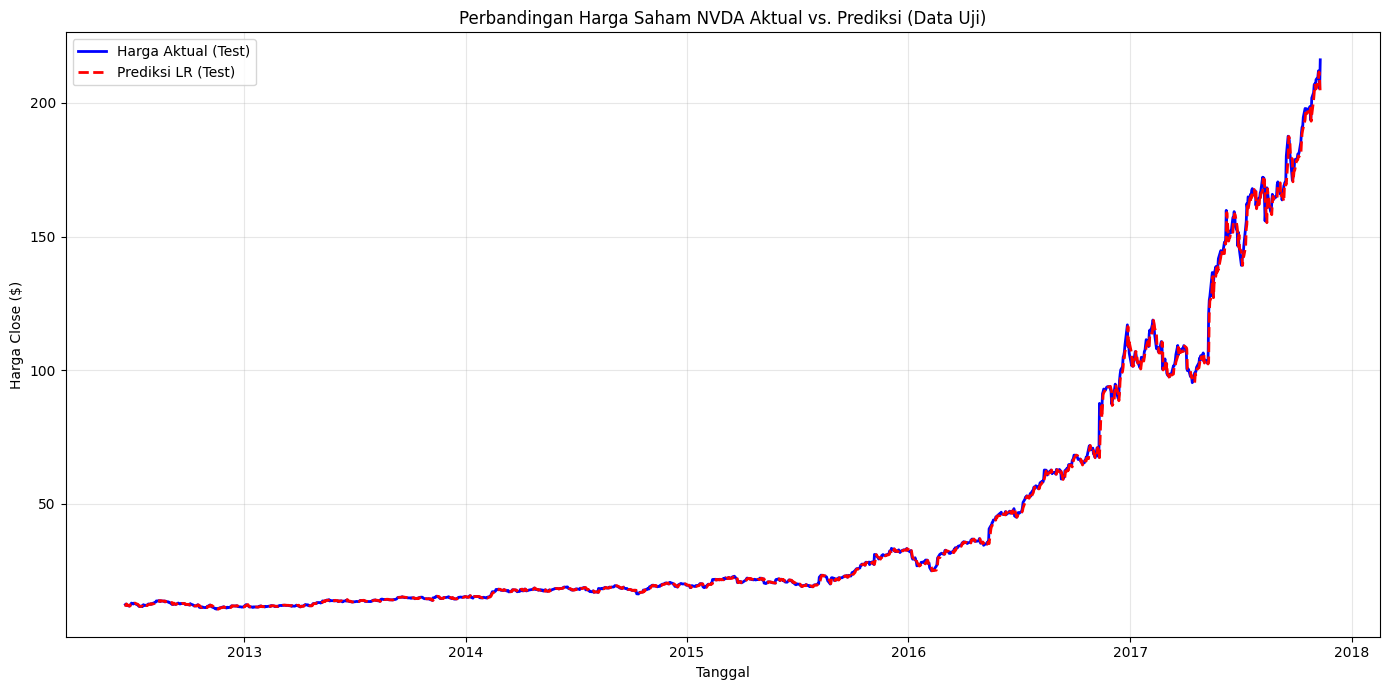

In [59]:
# --- VISUALISASI AKTUAL vs PREDIKSI (DATA UJI) ---
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

# Plot Harga Aktual (Data Y_test)
plt.plot(Y_test.index, Y_test.values, label='Harga Aktual (Test)', color='blue', linewidth=2)

# Plot Prediksi Model (Data lr_pred)
plt.plot(X_test.index, lr_pred, label='Prediksi LR (Test)', color='red', linestyle='--', linewidth=2)

plt.title('Perbandingan Harga Saham NVDA Aktual vs. Prediksi (Data Uji)')
plt.xlabel('Tanggal')
plt.ylabel('Harga Close ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('test_set_actual_vs_predicted.png')

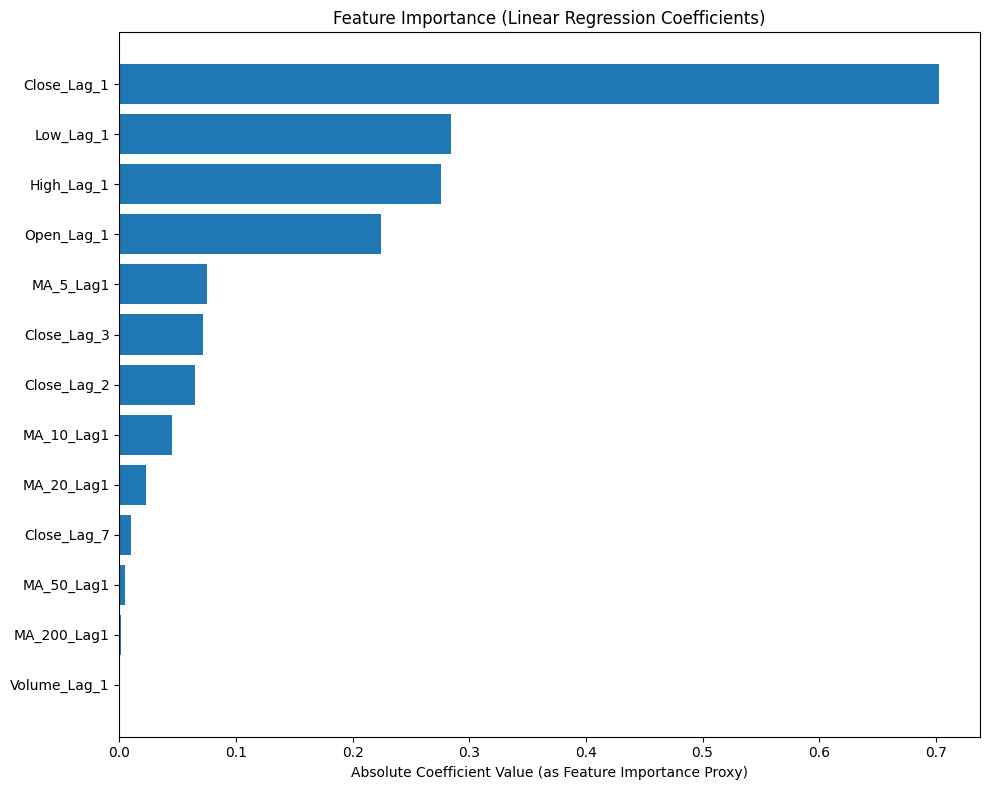

In [60]:
# Melihat Feature berpengaruh
importances = np.abs(lr_model.coef_)

feature_names = X_train.columns

indices = np.argsort(importances)

importances_sorted = importances[indices]
feature_names_sorted = feature_names[indices]

plt.figure(figsize=(10, 8))
plt.barh(range(X_train.shape[1]), importances_sorted, align="center")
plt.yticks(range(X_train.shape[1]), feature_names_sorted)
plt.xlabel("Absolute Coefficient Value (as Feature Importance Proxy)")
plt.title("Feature Importance (Linear Regression Coefficients)")
plt.tight_layout()
plt.savefig("feature_importances_lr.png")

### Evaluation

In [61]:
print("\n--- Evaluasi Model (Data Uji) ---")
mae = mean_absolute_error(Y_test, lr_pred)
rmse = np.sqrt(mean_squared_error(Y_test, lr_pred))
r2 = r2_score(Y_test, lr_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2): {r2:.4f}")


--- Evaluasi Model (Data Uji) ---
Mean Absolute Error (MAE): 0.7400
Root Mean Squared Error (RMSE): 1.6981
R-squared (R2): 0.9988


### Predict the Market

In [62]:
def recursive_forecast_advanced(model, history_df, steps=5):
    predictions = []
    future_dates = []

    current_history = history_df.copy()
    last_date = current_history.index[-1]

    for i in range(steps):
        close_lag_1 = current_history['Close'].iloc[-1]
        close_lag_2 = current_history['Close'].iloc[-2]
        close_lag_3 = current_history['Close'].iloc[-3]
        close_lag_7 = current_history['Close'].iloc[-7]

        ma_5  = current_history['Close'].iloc[-5:].mean()
        ma_10 = current_history['Close'].iloc[-10:].mean()
        ma_20 = current_history['Close'].iloc[-20:].mean()
        ma_50 = current_history['Close'].iloc[-50:].mean()
        ma_200 = current_history['Close'].iloc[-200:].mean()

        open_lag_1 = current_history['Open'].iloc[-1]
        high_lag_1 = current_history['High'].iloc[-1]
        low_lag_1  = current_history['Low'].iloc[-1]
        volume_lag_1 = current_history['Volume'].iloc[-1]

        features = np.array([[
            close_lag_1, close_lag_3,
            ma_5, ma_10, ma_20,
            open_lag_1, high_lag_1, low_lag_1, volume_lag_1,
            close_lag_2, close_lag_7, ma_50, ma_200
        ]])

        pred_close = model.predict(features)[0]
        predictions.append(pred_close)

        next_date = last_date + pd.Timedelta(days=1)
        while next_date.weekday() >= 5:
            next_date += pd.Timedelta(days=1)
        last_date = next_date
        future_dates.append(next_date)

        volatility = current_history['Close'].diff().std()
        if np.isnan(volatility): volatility = 0

        sim_open = pred_close
        sim_high = pred_close + volatility
        sim_low  = pred_close - volatility
        sim_vol  = current_history['Volume'].iloc[-5:].mean()

        new_row = pd.DataFrame({
            'Open': [sim_open],
            'High': [sim_high],
            'Low': [sim_low],
            'Close': [pred_close],
            'Volume': [sim_vol]
        }, index=[next_date])

        current_history = pd.concat([current_history, new_row])

    return np.array(predictions), pd.Index(future_dates)


In [63]:
initial_history = df.iloc[-250:]

future_preds, future_dates = recursive_forecast_advanced(
    lr_model,           # Model Linear Regression yang sudah dilatih
    initial_history, # Data history terakhir
    steps=5        # Mau prediksi berapa hari ke depan?
)

for date, price in zip(future_dates, future_preds):
    print(f"{date.date()}: ${price:.2f}")

2017-11-13: $216.24
2017-11-14: $215.21
2017-11-15: $214.88
2017-11-16: $214.56
2017-11-17: $214.02


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


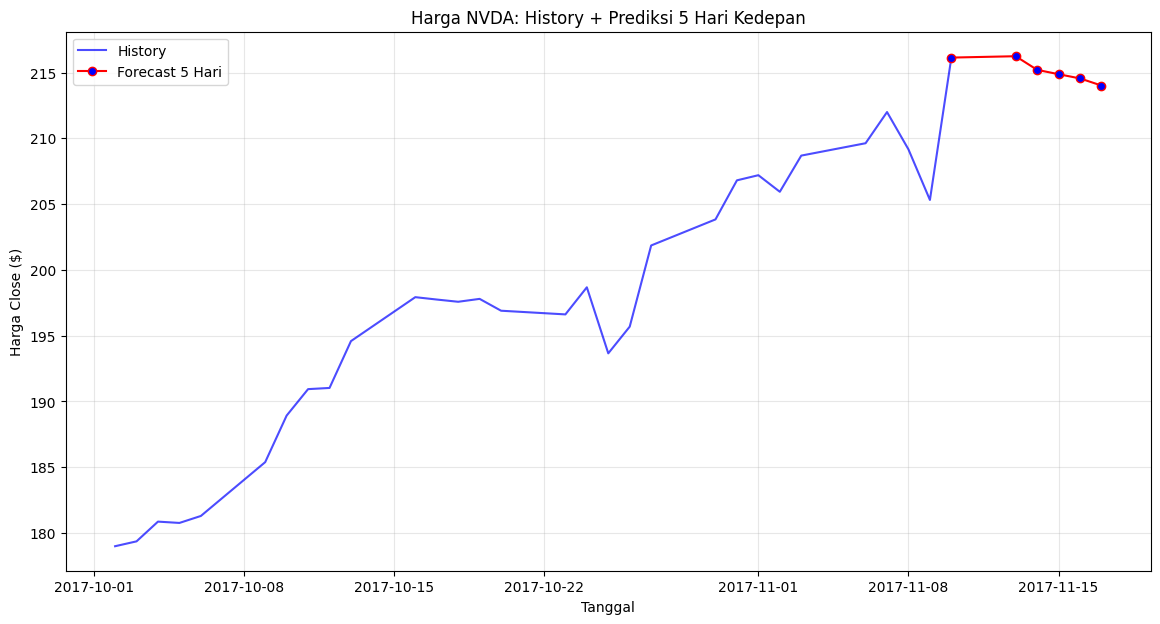

In [64]:
# Visualisasi nyambung dengan harga asli
start_date = '2017-10-01'
history_to_plot = df[df.index >= start_date]

plt.figure(figsize=(14, 7))
plt.plot(history_to_plot.index, history_to_plot['Close'], label='History', color='blue', alpha=0.7)

last_history_price = history_to_plot['Close'].iloc[-1]
pred_values_with_last = np.concatenate([[last_history_price], future_preds])
pred_dates_with_last = pd.Index([history_to_plot.index[-1]]).append(future_dates)

plt.plot(pred_dates_with_last, pred_values_with_last,
         label='Forecast 5 Hari',
         color='red',               # warna garis
         linestyle='-',
         marker='o',
         markerfacecolor='blue',    # isi lingkaran
         markeredgecolor='red')     # tepi lingkaran sama seperti garis

plt.title('Harga NVDA: History + Prediksi 5 Hari Kedepan')
plt.xlabel('Tanggal')
plt.ylabel('Harga Close ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()




## Model LSTM

In [65]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data.values.reshape(-1, 1))

In [66]:
def create_dataset(dataset, window_size=10):
    X, y = [], []
    for i in range(len(dataset)-window_size):
        X.append(dataset[i:i+window_size])
        y.append(dataset[i+window_size])
    return np.array(X), np.array(y)

window = 10
X, y = create_dataset(data_scaled, window)


In [67]:
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [68]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test  = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [69]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(window,1)),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 10, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,025 (457.13 KB)

 Trainable params: 117,025 (457.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=16,
    callbacks=[es],
    verbose=1
)

Epoch 1/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 3.3748e-04 - val_loss: 6.2722e-04
Epoch 2/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 3.8094e-05 - val_loss: 3.2040e-04
Epoch 3/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 3.1344e-05 - val_loss: 3.7285e-04
Epoch 4/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 2.4578e-05 - val_loss: 3.2328e-04
Epoch 5/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 2.2753e-05 - val_loss: 2.0910e-04
Epoch 6/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 2.4910e-05 - val_loss: 2.5527e-04
Epoch 7/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 2.8536e-05 - val_loss: 5.0967e-04
Epoch 8/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 2.2586e-05 - val_loss: 6.8766e-04
Epoch 9/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 2.0814e-05 - val_loss: 0.0012
Epoch 10/100
236/237 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.8835e-05

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

In [ ]:
y_pred_scaled = model.predict(X_test).reshape(-1,1)
y_test_scaled = y_test.reshape(-1,1)

y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test_scaled)

In [ ]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_true, y_pred)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MAE:  {mae:.6f}")
print(f"MSE:  {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"R2:   {r2:.6f}")

In [ ]:
test_index = df.index[ (len(df) - len(y_true)) : ]  # dates corresponding to y_test
plt.figure(figsize=(12,5))
plt.plot(test_index, y_true, label='Actual')
plt.plot(test_index, y_pred, label='Predicted (LSTM)', alpha=0.9)
plt.title('Actual vs Predicted (Test set)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [ ]:
# --- PERBAIKAN LOGIKA FORECASTING ---

# 1. Ambil 10 data terakhir dari harga ASLI
last_window_raw = df['Close'].values[-window:].reshape(-1, 1)

# 2. PENTING: Lakukan SCALING agar formatnya sama dengan saat training (0-1)
curr_input_scaled = scaler.transform(last_window_raw).reshape(1, window, 1)

future_preds_scaled = []
future_steps = 5

# 3. Loop Prediksi
for i in range(future_steps):
    # Prediksi langkah berikutnya (hasil masih dalam skala 0-1)
    next_pred = model.predict(curr_input_scaled, verbose=0)[0][0]

    # Simpan hasil scaled
    future_preds_scaled.append(next_pred)

    # Update input: Buang data terlama (indeks 0), masukkan prediksi baru ke paling belakang
    # Bentuk array harus (1, 1, 1) agar bisa di-append
    next_input = np.array([[[next_pred]]])
    curr_input_scaled = np.append(curr_input_scaled[:, 1:, :], next_input, axis=1)

# 4. Kembalikan hasil prediksi ke harga asli (Dollar) menggunakan inverse_transform
future_preds_actual = scaler.inverse_transform(np.array(future_preds_scaled).reshape(-1, 1)).flatten()

# 5. Siapkan Tanggal Masa Depan
last_date = df.index[-1]
future_dates = [last_date + pd.Timedelta(days=i+1) for i in range(future_steps)]

# 6. Plotting Hasil
plt.figure(figsize=(14, 7))

# Plot data history (ambil 50 hari terakhir biar jelas)
history_part = df['Close'].iloc[-50:]
plt.plot(history_part.index, history_part.values, label='History', color='blue')

# Plot data prediksi
plt.plot(future_dates, future_preds_actual, label='5-Day Forecast', color='red', marker='o', linestyle='--')

# Agar garisnya nyambung (kosmetik visual)
plt.plot([history_part.index[-1], future_dates[0]],
         [history_part.values[-1], future_preds_actual[0]],
         color='red', linestyle='--', alpha=0.5)

plt.title('LSTM Forecasting - Corrected Scale')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print angka prediksi
print("Prediksi 5 Hari ke Depan:")
for d, p in zip(future_dates, future_preds_actual):
    print(f"{d.date()}: ${p:.2f}")